In [21]:
from gensim.models import Word2Vec
import tensorflow as tf
import os
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np



In [22]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [23]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_model_word2vec = os.path.join(parent_dir[0], "Pre-processamento\\model_word2vec.model")

# Carrega o modelo Word2Vec para um arquivo
model_word2vec = Word2Vec.load(caminho_model_word2vec)

In [24]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

print("max_length: ", max_length)

max_length:  3835


In [25]:
# Carrega dataframe salvo em formato pickle
caminho_noticias = os.path.join(parent_dir[0],"Pre-processamento\\df_pre_processado.pkl")

with open(caminho_noticias, 'rb') as f:
    df = pickle.load(f)

df

,Texto,Categoria,label
0,"[poder, decidir, expulsar, deputado, federal, ...",Real,1
1,"[bolsonaro, liberal, completo, presidente, psl...",Real,1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",Real,1
3,"[apesar, abundancia, crescer, preocupacao, pre...",Real,1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",Real,1
...,...,...,...
22279,"[encontrar, reunir, presidente, jair, Bolsonar...",Falso,0
22280,"[reabertura, complexo, parque, disney, orlar, ...",Falso,0
22281,"[publicacao, circular, rede, social, pedir, mi...",Real,1
22282,"[juiz, Wauner, Batista, Ferreiro, machadar, va...",Falso,0


In [26]:
# Carrega os rótulos (labels) de um arquivo pickle
caminho_labels = os.path.join(parent_dir[0],"Pre-processamento\\labels.pkl")
with open(caminho_labels, 'rb') as f:
    labels = pickle.load(f)

In [27]:
# Carrega os dados de treino de um arquivo pickle
caminho_treino = os.path.join(parent_dir[0],"Pre-processamento\\train_data.pkl")
with open(caminho_treino, 'rb') as f:
    X_train, y_train = pickle.load(f)

print("Dados treinamento carregados: ", X_train, y_train)

# Carrega os dados de validação de um arquivo pickle
caminho_validacao = os.path.join(parent_dir[0],"Pre-processamento\\val_data.pkl")
with open(caminho_validacao, 'rb') as f:
    X_val, y_val = pickle.load(f)

print("Dados validação carregados: ", X_val, y_val)

# Carrega os dados de teste de um arquivo pickle
caminho_teste = os.path.join(parent_dir[0],"Pre-processamento\\test_data.pkl")
with open(caminho_teste, 'rb') as f:
    X_test, y_test = pickle.load(f)

print("Dados teste carregados: ", X_test, y_test)

Dados treinamento carregados:  [[  351   565    67 ...     0     0     0]
 [   66 78330   318 ...     0     0     0]
 [ 2431  2404   579 ...     0     0     0]
 ...
 [  229 12291  1054 ...     0     0     0]
 [12618  9196   670 ... 26460     1   121]
 [    2  2597  7549 ...     0     0     0]] [[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Dados validação carregados:  [[ 216   29    1 ...    0    0    0]
 [  63   13 3150 ...    0    0    0]
 [ 548  454  296 ...    0    0    0]
 ...
 [ 636 5280   88 ...    0    0    0]
 [6776  158 3653 ...    0    0    0]
 [2863  100  194 ...    0    0    0]] [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
Dados teste carregados:  [[ 138   48   26 ...    0    0    0]
 [   2  312 3701 ...    0    0    0]
 [1882 1627   50 ...    0    0    0]
 ...
 [  14  762  174 ...    0    0    0]
 [  41   76 4954 ...    0    0    0]
 [ 138   48   26 ...    0    0    0]] [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [28]:
# Cria modelo BiLSTM
model = Sequential()
model.add(Embedding(input_dim=len(model_word2vec.wv.key_to_index) + 1, 
                    output_dim=model_word2vec.vector_size))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=64, return_sequences=True, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.001))))
model.add(Dense(units=len(labels[0]), activation='softmax'))

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# Compila modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina modelo
history = model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/40
244/244 [==============================] - 140s 530ms/step - loss: 0.6441 - accuracy: 0.8111 - val_loss: 0.3704 - val_accuracy: 0.8771
Epoch 2/40
244/244 [==============================] - 127s 522ms/step - loss: 0.2342 - accuracy: 0.9321 - val_loss: 0.3987 - val_accuracy: 0.8403
Epoch 3/40
244/244 [==============================] - 152s 625ms/step - loss: 0.1710 - accuracy: 0.9514 - val_loss: 0.5092 - val_accuracy: 0.8106
Epoch 4/40
244/244 [==============================] - 149s 612ms/step - loss: 0.2387 - accuracy: 0.9276 - val_loss: 0.4204 - val_accuracy: 0.8705
Epoch 5/40
244/244 [==============================] - 131s 539ms/step - loss: 0.0896 - accuracy: 0.9800 - val_loss: 0.4159 - val_accuracy: 0.8809


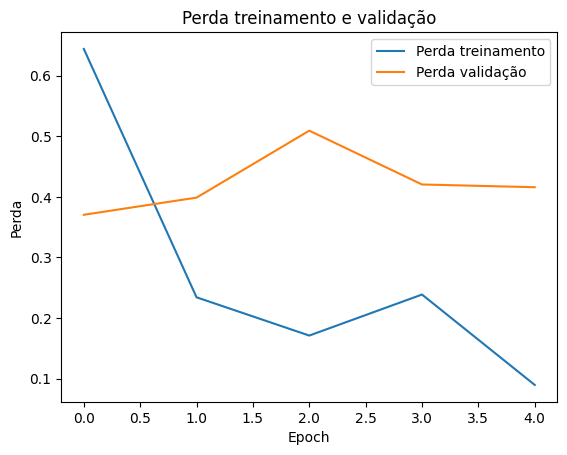

In [29]:
# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda treinamento')
plt.plot(history.history['val_loss'], label='Perda validação')
plt.title('Perda treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [30]:
# Salva arquivos em discos que podemos carregar sem treinar a rede neural novamente
model.save('BiLSTM_model.h5')
np.save("X_test_BiLSTM.npy", X_test)
np.save("y_test_BiLSTM.npy", y_test)